 ### Load the drive containing data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

### Defining function to group less represented parties under the 'Others' category

In [3]:
def creating_category_others(data):
  # Using 0.99 quantile to categorize 'Others'
  threshold_value = data['count'].quantile(.99)
  values_below_thresh = data['count'] < threshold_value
  data.loc[values_below_thresh,'Label'] = 'Others'
  return data

## Loading datasets

In [4]:
# Load dataset containing sport quotes
dataset = pd.read_csv('/content/drive/MyDrive/ADA/ada-sports-quotes/sport-quotes-2018.csv.bz2', compression='bz2', usecols=['speaker','qids','quoteID'])

# Load speaker attributes from Google Drive
speaker_attributes = pd.read_parquet('/content/drive/MyDrive/ADA/Project datasets/speaker_attributes.parquet', columns=['nationality','party','id'])

# Load the database relating qids with wikidata labels
qid_labels = pd.read_csv('/content/drive/MyDrive/ADA/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

In [5]:
# Removing square brackets and quotation marks from qids to match the speaker_attributes dataset
dataset['qids'] = dataset['qids'].str.strip('[\'\']')
speakers = speaker_attributes[speaker_attributes['id'].isin(dataset['qids'])]

# Removing speakers without any known party (i.e. with 'party' == None)
politicians = speakers[~(speakers['party'].isna())]

## Computing the number of speakers per party from sport quotes

Only keeping the first qid for the 'party' feature. It is known, that it is not correct because we should select the party in which the speaker was at the time of the quote. This will be solved for Milestone 3, as this requires new speaker_features dataset to obtain this information. 

In [6]:
# Only keeping the first qid in the 'party' feature (with str.get(0))
# Counts the occurences of each party and adding the corresponding party label by merging qid_labels
party_speaker_counts_label = pd.DataFrame(pd.value_counts(politicians['party'].str.get(0))).merge(qid_labels, left_index=True, right_on='QID').rename(columns={'party': 'count'})

# Setting label of party with count lower than the 0.99 quantile to 'Others'
party_speaker_counts_label = creating_category_others(party_speaker_counts_label)

## Computing the number of quotes per party from sport quotes

In [7]:
# Selecting quotes from a speaker with a party and merging the speaker_attributes dataset
dataset_politicians_attributes = dataset[dataset['qids'].isin(politicians['id'])].merge(speaker_attributes, left_on='qids', right_on='id')
# Only keeping the first qid in the 'party' feature (with str.get(0))
dataset_politicians_attributes['party'] = dataset_politicians_attributes['party'].str.get(0)

# Counts the occurences of each party and add the corresponding party label 
party_quotes_counts_label = pd.DataFrame(pd.value_counts(dataset_politicians_attributes['party'])).merge(qid_labels, left_index=True, right_on='QID').rename(columns={'party': 'count'})

# Setting label of party with count lower than the 0.99 quantile to 'Others'
party_quotes_counts_label = creating_category_others(party_quotes_counts_label)

## Plots : pie plots and bar plots

Speaker's party distribution

Text(0.6, 0.92, "Speaker's party distribution of sport quotes for year 2018")

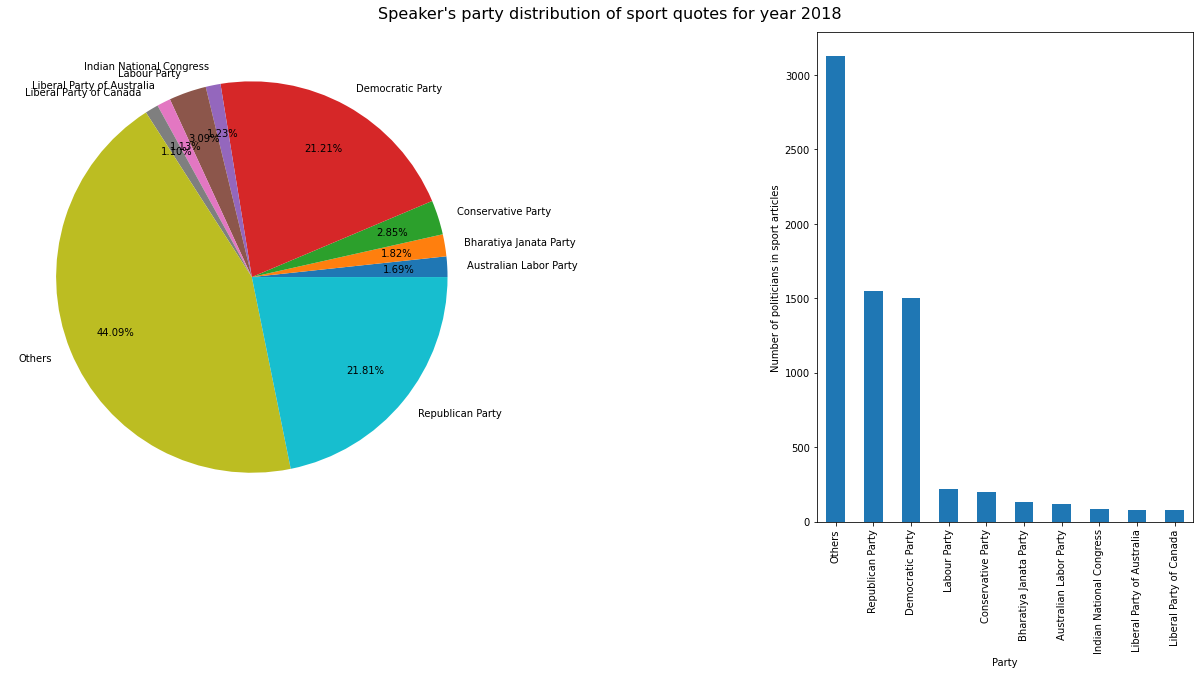

In [8]:
fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(27,9))

party_speaker_counts_label.groupby('Label').sum().plot(kind='pie', subplots=True, legend=False, autopct='%1.2f%%', ax=axes[0], pctdistance=0.75, ylabel='')
party_speaker_counts_label.groupby('Label').sum().sort_values(by='count', ascending=False).plot(kind='bar',legend=False, log=False, ax=axes[1], ylabel='Number of politicians in sport articles', xlabel='Party')

plt.subplots_adjust(wspace=0)
fig.suptitle('Speaker\'s party distribution of sport quotes for year 2018', fontsize=16, x=0.6, y=0.92)

Quote's party distribution

Text(0.6, 0.92, "Quote's party distribution of sport quotes for year 2018")

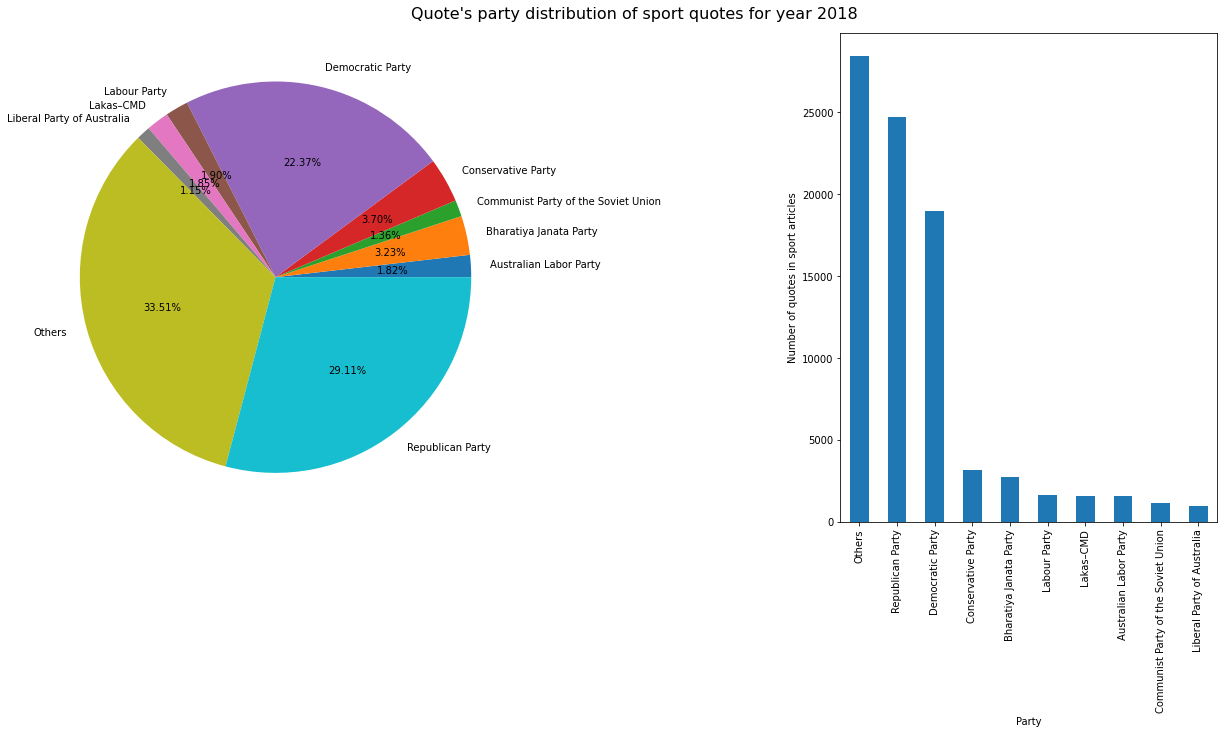

In [9]:
fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(27,9))

party_quotes_counts_label.groupby('Label').sum().plot(kind='pie', subplots=True, legend=False, autopct='%1.2f%%', ax=axes[0], ylabel='')
party_quotes_counts_label.groupby('Label').sum().sort_values(by='count', ascending=False).plot(kind='bar',legend=False, log=False, ax=axes[1], ylabel='Number of quotes in sport articles', xlabel='Party')

plt.subplots_adjust(wspace=0)
fig.suptitle('Quote\'s party distribution of sport quotes for year 2018', fontsize=16, x=0.6, y=0.92)

## Data description and overview

Lengths of DataFrame (i.e. number of sample)

In [10]:
print('Number of sport quotes: {q_sport}\nNumber of political quotes: {q_pol}\nNumber of speakers: {spea}\nNumber of politicians (i.e. speakers with political party): {pol}\nNumber of different parties: {part}'\
      .format(q_sport=dataset.shape[0], spea=speakers.shape[0], pol=politicians.shape[0], part=party_speaker_counts_label.shape[0], q_pol=dataset_politicians_attributes.shape[0]))

Number of sport quotes: 4274811
Number of political quotes: 84907
Number of speakers: 85615
Number of politicians (i.e. speakers with political party): 7097
Number of different parties: 813


In [11]:
dataset.sample(5)

,quoteID,speaker,qids
3383923,2018-07-06-108515,Jeff Banister,Q6173283
703607,2018-11-16-100719,None,
952219,2018-06-11-111677,John Gibbons,"Q19953474', 'Q21557552', 'Q27074107', 'Q301220..."
3788420,2018-01-12-043623,Nate Sudfeld,Q21066710
2885182,2018-03-09-164549,Alex Cora,Q595978


In [12]:
speakers.sample(5)

,nationality,party,id
7093736,[Q16],None,Q16215016
32051,[Q1183],None,Q945546
12860,[Q145],"[Q3179541, Q9630]",Q333820
3501028,[Q668],None,Q3631406
5677612,[Q16],None,Q457065


In [13]:
politicians.sample(5)

,nationality,party,id
360636,None,[Q29468],Q20708218
8102307,[Q30],[Q29468],Q6391069
5677933,[Q30],[Q29552],Q461746
1203540,"[Q15180, Q159]",[Q4232166],Q2210595
1559635,None,[Q29468],Q29169083


In [14]:
party_speaker_counts_label.head(5)

,count,Label,Description
QID,,,
Q29468,1548,Republican Party,major political party in the United States
Q29552,1505,Democratic Party,political party in the United States
Q9630,219,Labour Party,political party in the United Kingdom
Q9626,202,Conservative Party,political party in the United Kingdom
Q10230,129,Bharatiya Janata Party,major political party in India


In [15]:
dataset_politicians_attributes.sample(5)

,quoteID,speaker,qids,nationality,party,id
24420,2018-03-29-141398,Rajeev Shukla,Q7285952,[Q668],Q10225,Q7285952
69439,2018-11-28-114115,Joel Villanueva,Q12963666,[Q928],Q1476937,Q12963666
22230,2018-01-30-033375,Vic Miller,Q30166067,None,Q29552,Q30166067
76594,2018-05-04-071361,Rob Kane,Q19560928,[Q30],Q29468,Q19560928
67111,2018-09-27-089522,Kiren Rijiju,Q6415053,[Q668],Q10230,Q6415053


In [16]:
party_quotes_counts_label.head(5)

,count,Label,Description
QID,,,
Q29468,24715,Republican Party,major political party in the United States
Q29552,18993,Democratic Party,political party in the United States
Q9626,3139,Conservative Party,political party in the United Kingdom
Q10230,2741,Bharatiya Janata Party,major political party in India
Q9630,1617,Labour Party,political party in the United Kingdom
